# Importing all the required libraries

In [70]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder , PowerTransformer , FunctionTransformer , PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit, GridSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer , IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from scipy.stats import iqr
import joblib
import warnings
warnings.filterwarnings('ignore')

# Load and Inspect Data

In [71]:
df = pd.read_csv('/content/city_day.csv' , low_memory=False)

# df.drop(columns=['StationId'] , inplace=True)
# df['Id'] = range(1, len(df) + 1)
# df.set_index('Id' , inplace=True)

In [72]:
cols = ['AQI' , 'AQI_Bucket' , 'Xylene' , 'Toluene' , 'Benzene' , 'O3' , 'SO2' , 'CO' , 'NH3' , 'NOx' , 'NO2' , 'NO' , 'PM10' , 'PM2.5']
indices = df[df[cols].isnull().all(axis=1)].index

In [73]:
df.drop(indices , inplace=True)

In [74]:
df.shape

(28157, 16)

In [75]:
df.isnull().sum()

City              0
Date              0
PM2.5          3224
PM10           9766
NO             2208
NO2            2211
NOx            2811
NH3            8954
CO              685
SO2            2480
O3             2648
Benzene        4249
Toluene        6667
Xylene        16735
AQI            3307
AQI_Bucket     3307
dtype: int64

In [76]:
df.head()

City        Date  PM2.5  PM10     NO    NO2    NOx  NH3     CO    SO2  \
0  Ahmedabad  2015-01-01    NaN   NaN   0.92  18.22  17.15  NaN   0.92  27.64   
1  Ahmedabad  2015-01-02    NaN   NaN   0.97  15.69  16.46  NaN   0.97  24.55   
2  Ahmedabad  2015-01-03    NaN   NaN  17.40  19.30  29.70  NaN  17.40  29.07   
3  Ahmedabad  2015-01-04    NaN   NaN   1.70  18.48  17.97  NaN   1.70  18.59   
4  Ahmedabad  2015-01-05    NaN   NaN  22.10  21.42  37.76  NaN  22.10  39.33   

       O3  Benzene  Toluene  Xylene  AQI AQI_Bucket  
0  133.36     0.00     0.02    0.00  NaN        NaN  
1   34.06     3.68     5.50    3.77  NaN        NaN  
2   30.70     6.80    16.40    2.25  NaN        NaN  
3   36.08     4.43    10.14    1.00  NaN        NaN  
4   39.31     7.01    18.89    2.78  NaN        NaN

In [77]:
df.sample(5)

City        Date  PM2.5    PM10     NO    NO2    NOx    NH3    CO  \
16488  Hyderabad  2020-03-25  28.47   59.28   7.76  12.70  11.53  11.26  0.40   
4176    Amritsar  2020-03-06  17.61   61.51  17.42  11.14  26.82  12.00  0.74   
22185     Mumbai  2015-11-27    NaN     NaN    NaN    NaN  98.32    NaN  0.00   
2182   Amaravati  2018-01-23  79.01  138.14   6.16  45.43  29.17  20.29  0.06   
2104      Aizawl  2020-06-14   0.98    4.59  11.63   0.07  15.17  24.59  0.16   

         SO2     O3  Benzene  Toluene  Xylene    AQI    AQI_Bucket  
16488   6.22  28.67     1.02     4.75    0.40   60.0  Satisfactory  
4176   11.49  27.23     1.38     1.47    1.98   68.0  Satisfactory  
22185    NaN    NaN     0.00     0.00    0.00    NaN           NaN  
2182   10.18  58.04     0.18     5.76    0.07  163.0      Moderate  
2104    8.82   3.77      NaN      NaN     NaN   19.0          Good

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28157 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        28157 non-null  object 
 1   Date        28157 non-null  object 
 2   PM2.5       24933 non-null  float64
 3   PM10        18391 non-null  float64
 4   NO          25949 non-null  float64
 5   NO2         25946 non-null  float64
 6   NOx         25346 non-null  float64
 7   NH3         19203 non-null  float64
 8   CO          27472 non-null  float64
 9   SO2         25677 non-null  float64
 10  O3          25509 non-null  float64
 11  Benzene     23908 non-null  float64
 12  Toluene     21490 non-null  float64
 13  Xylene      11422 non-null  float64
 14  AQI         24850 non-null  float64
 15  AQI_Bucket  24850 non-null  object 
dtypes: float64(13), object(3)
memory usage: 4.7+ MB


In [79]:
df.describe().T

count        mean         std    min     25%     50%       75%  \
PM2.5    24933.0   67.450578   64.661449   0.04  28.820   48.57   80.5900   
PM10     18391.0  118.127103   90.605110   0.01  56.255   95.68  149.7450   
NO       25949.0   17.574730   22.785846   0.02   5.630    9.89   19.9500   
NO2      25946.0   28.560659   24.474746   0.01  11.750   21.69   37.6200   
NOx      25346.0   32.309123   31.646011   0.00  12.820   23.52   40.1275   
NH3      19203.0   23.483476   25.684275   0.01   8.580   15.85   30.0200   
CO       27472.0    2.248598    6.962884   0.00   0.510    0.89    1.4500   
SO2      25677.0   14.531977   18.133775   0.01   5.670    9.16   15.2200   
O3       25509.0   34.491430   21.694928   0.01  18.860   30.84   45.5700   
Benzene  23908.0    3.280840   15.811136   0.00   0.120    1.07    3.0800   
Toluene  21490.0    8.700972   19.969164   0.00   0.600    2.97    9.1500   
Xylene   11422.0    3.070128    6.323247   0.00   0.140    0.98    3.3500   
AQI      24850.0  166.463581  140.696585  13.00  81.000  118.00  208.0000   

             max  
PM2.5     949.99  
PM10     1000.00  
NO        390.68  
NO2       362.21  
NOx       467.63  
NH3       352.89  
CO        175.81  
SO2       193.86  
O3        257.73  
Benzene   455.03  
Toluene   454.85  
Xylene    170.37  
AQI      2049.00

In [80]:
numerical_cols = []
categorical_cols = []

for col in df.columns:
  if df[col].dtype == 'object':
    categorical_cols.append(col)
  else:
    numerical_cols.append(col)

In [ ]:
df['Datetime'] = df['Datetime'].astype('datetime64[ns]')

KeyError: 'Datetime'

In [ ]:
df['Date'] = df['Datetime'].dt.date
df['Day'] = df['Datetime'].dt.day
df['Month'] =  df['Datetime'].dt.month
df['Time'] = df['Datetime'].dt.time

# EDA

## Univariate Analysis

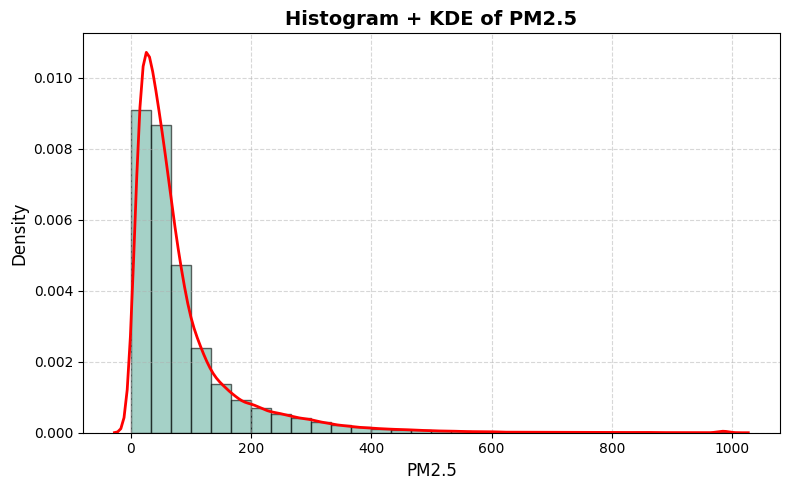

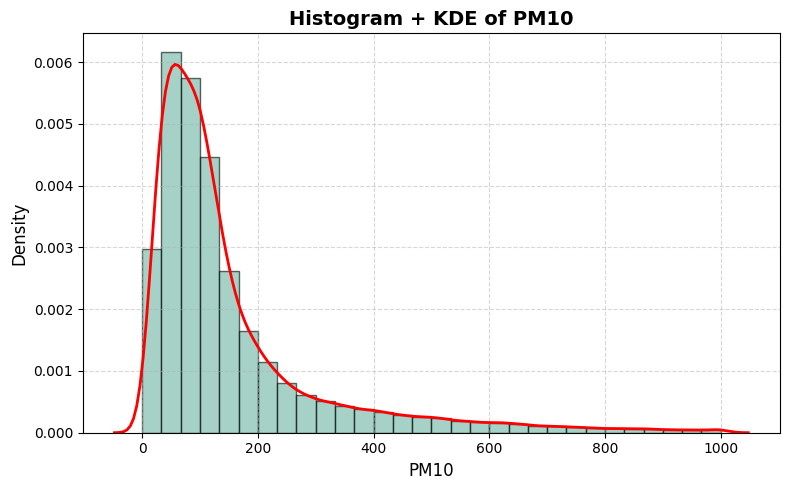

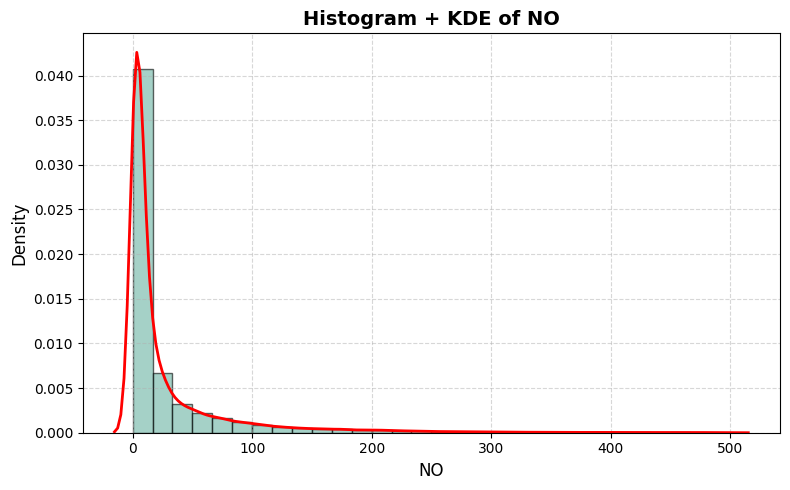

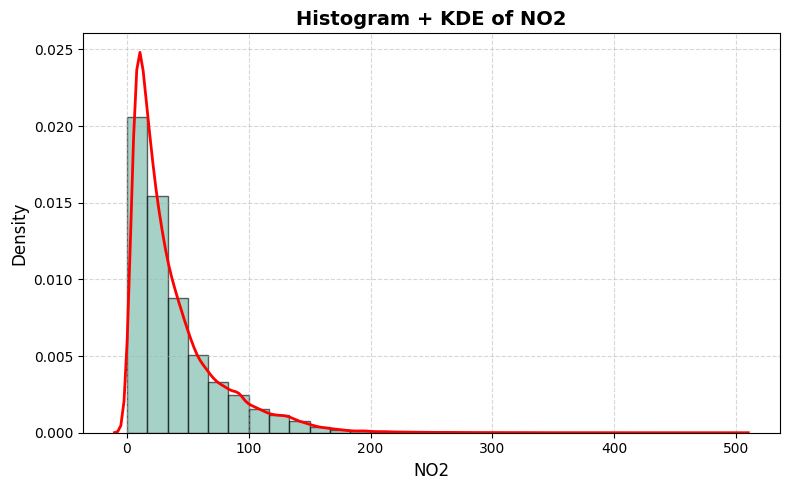

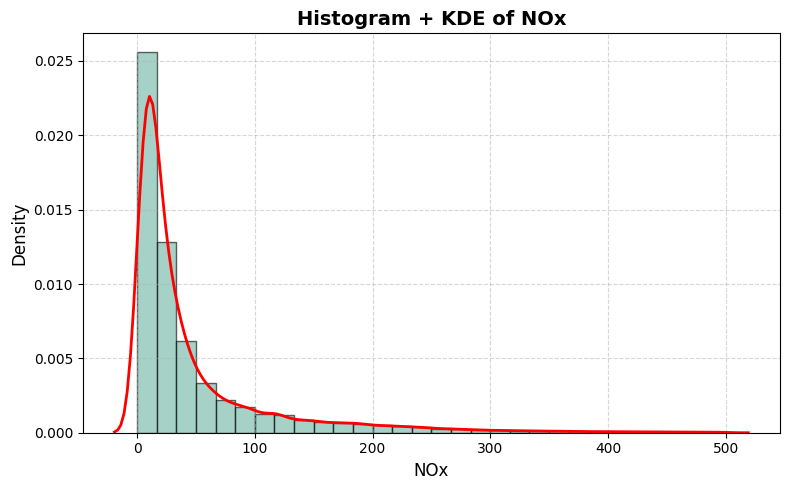

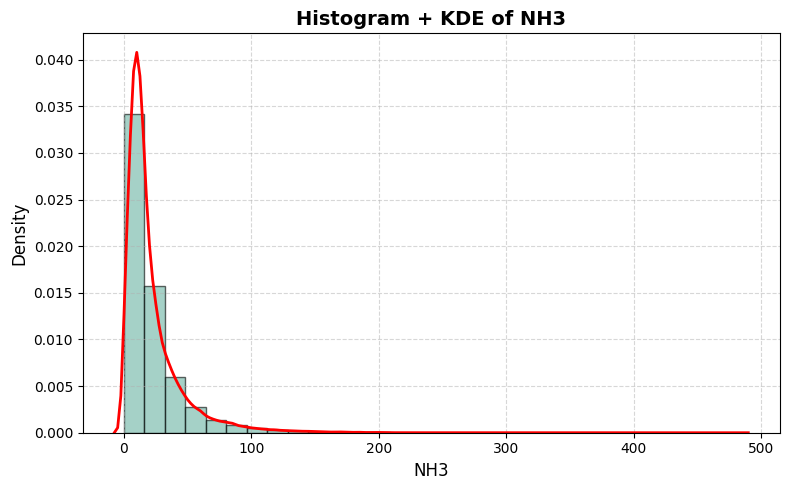

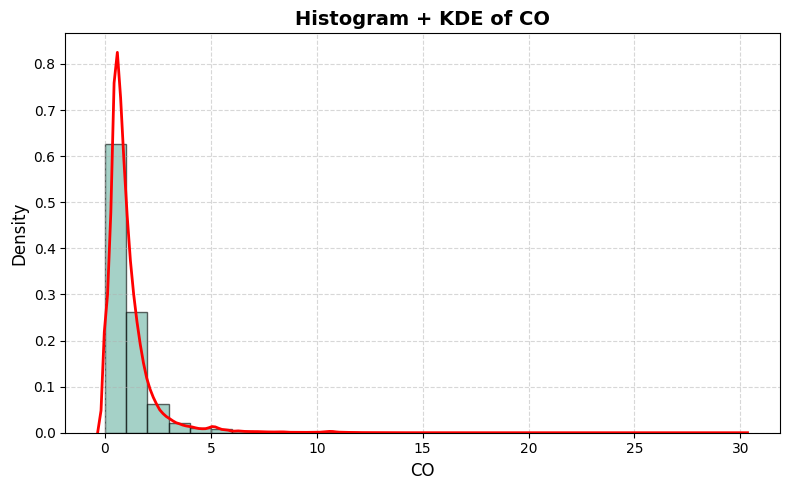

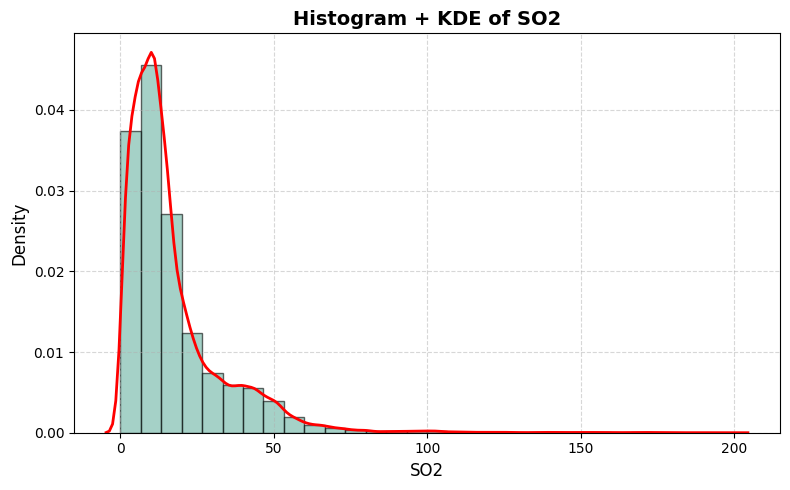

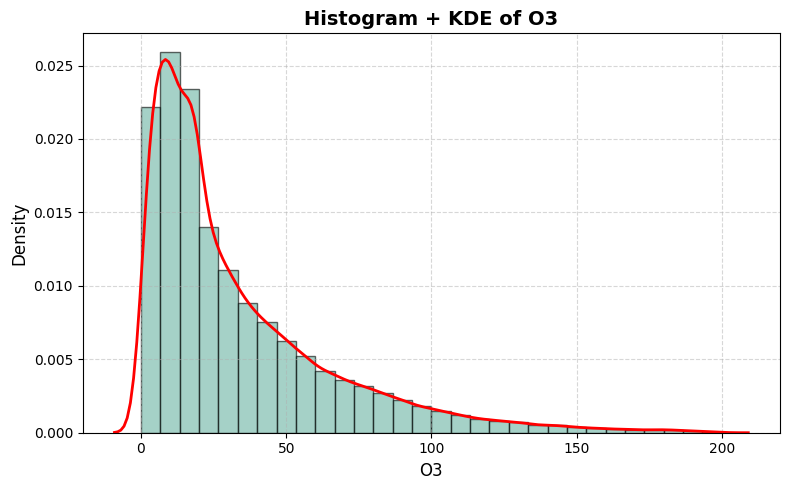

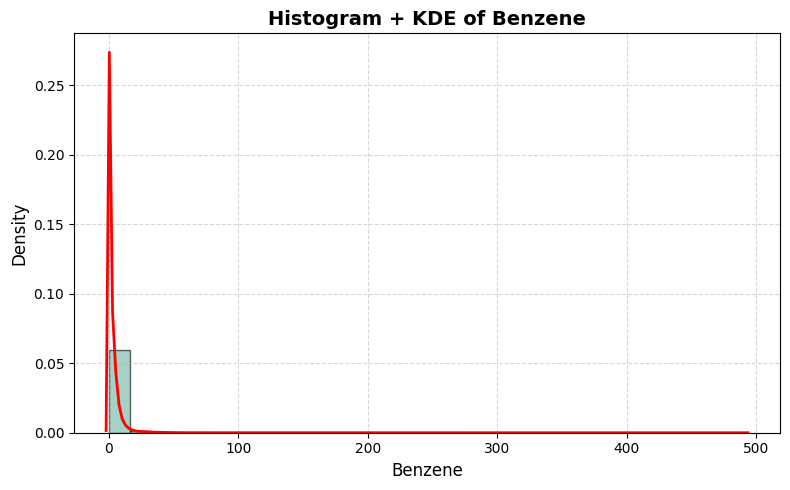

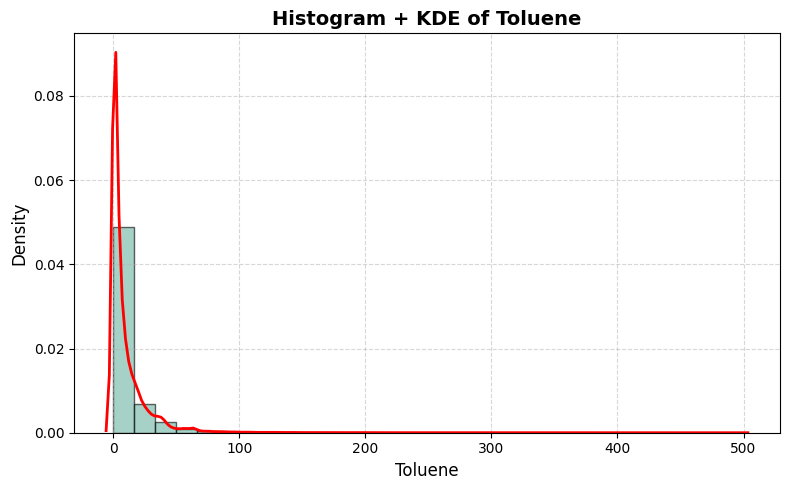

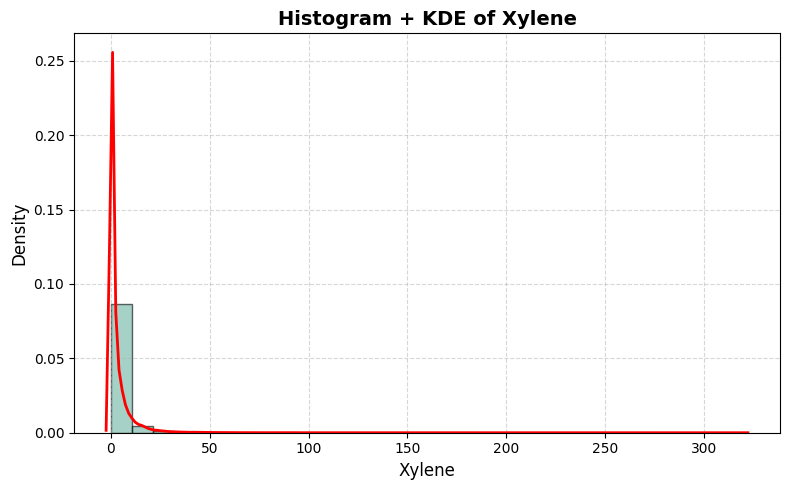

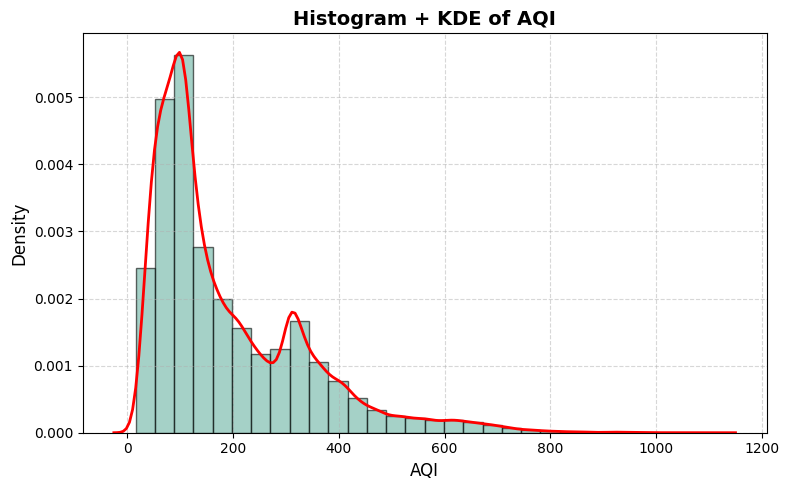

In [ ]:
for col in numerical_cols:
    plt.figure(figsize=(8, 5))

    # Plot histogram (density=True scales it for KDE overlay)
    plt.hist(df[col].dropna(), bins=30, density=True,
             alpha=0.6, color='#69b3a2', edgecolor='black')

    # Overlay KDE plot
    sns.kdeplot(df[col].dropna(), color='red', linewidth=2, bw_adjust=1)

    # Titles and labels
    plt.title(f'Histogram + KDE of {col}', fontsize=14, fontweight='bold')
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Density', fontsize=12)  # use Density, not Frequency, since scaled

    # Grid
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

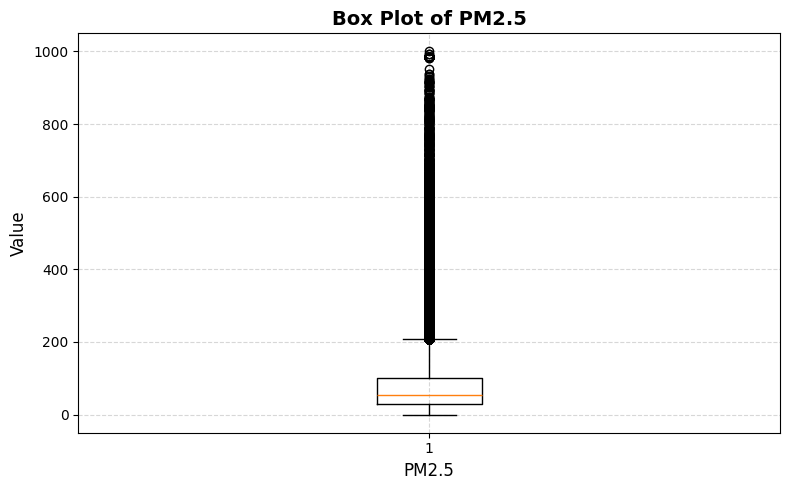

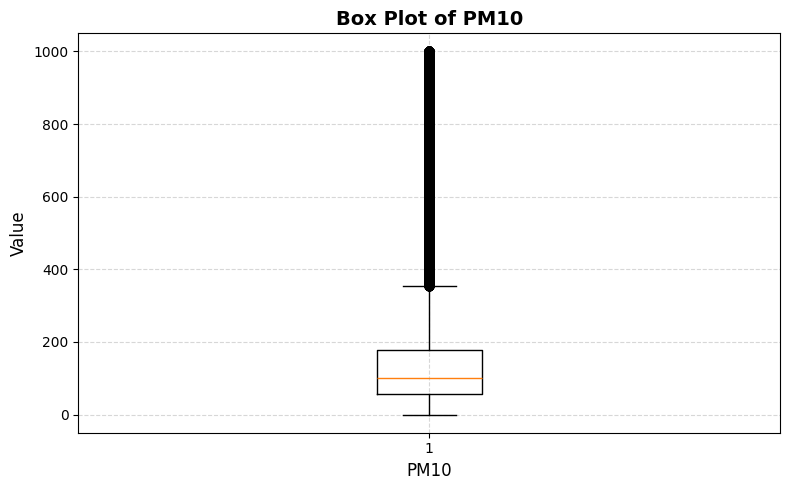

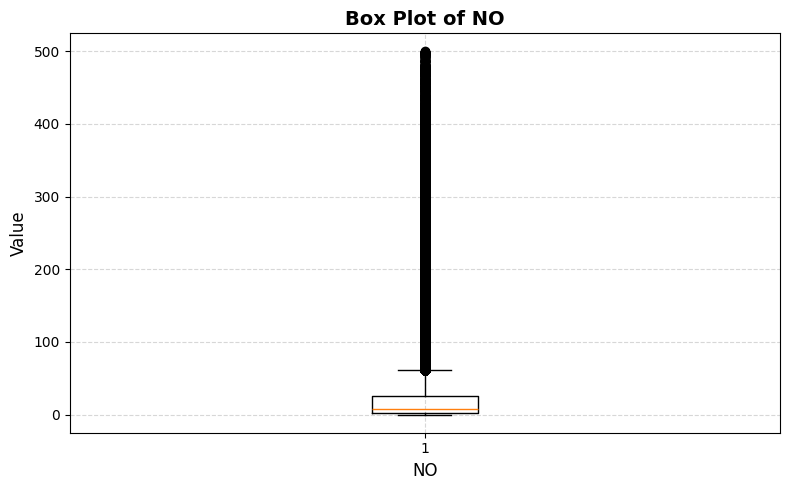

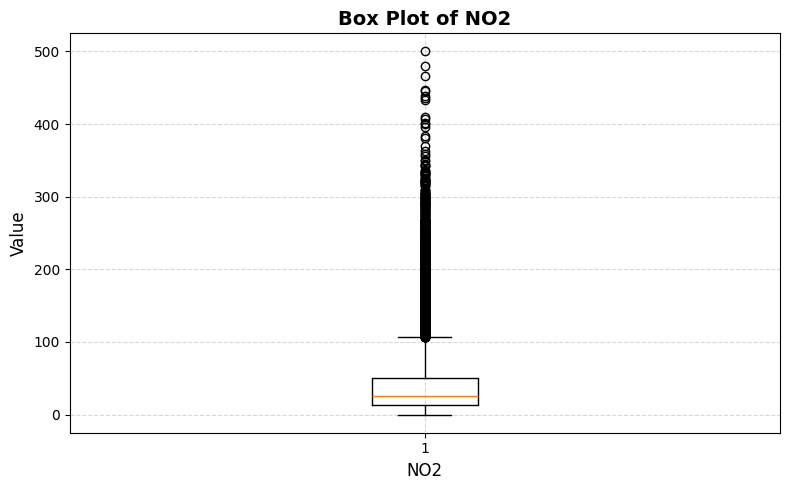

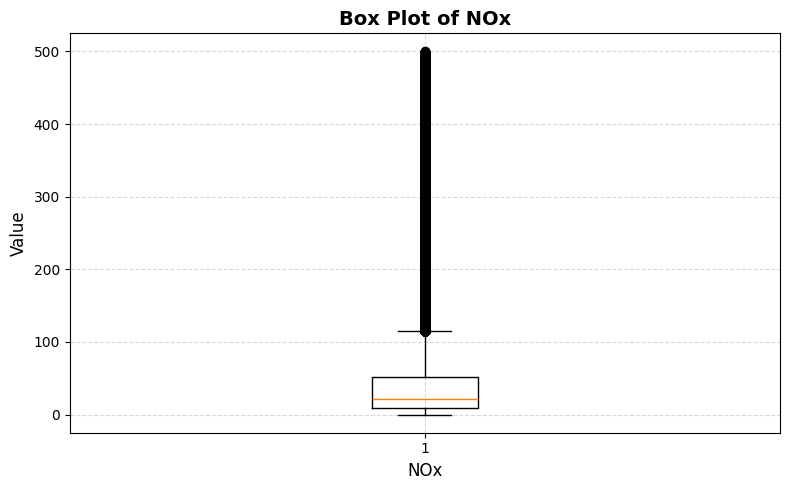

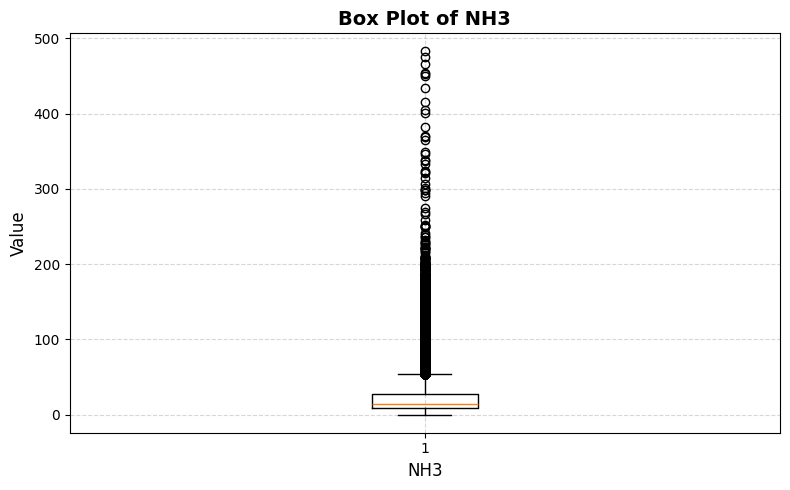

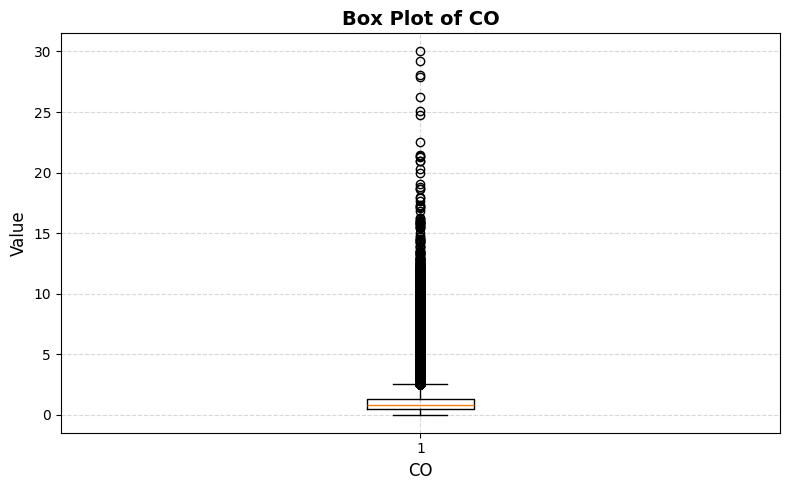

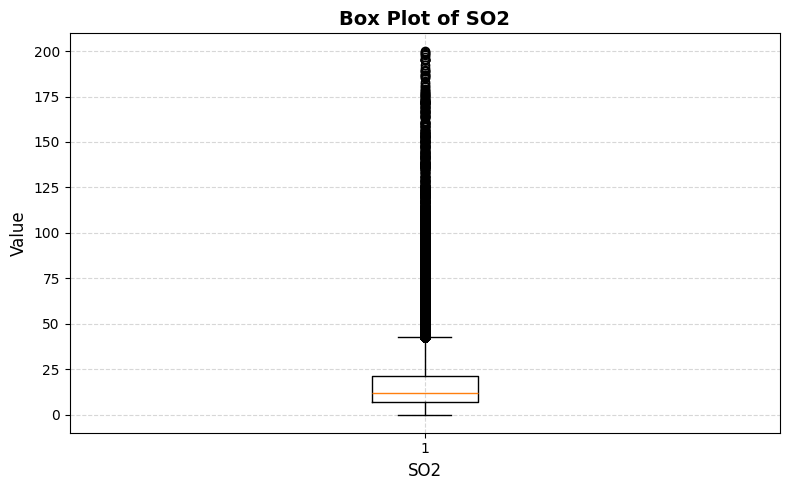

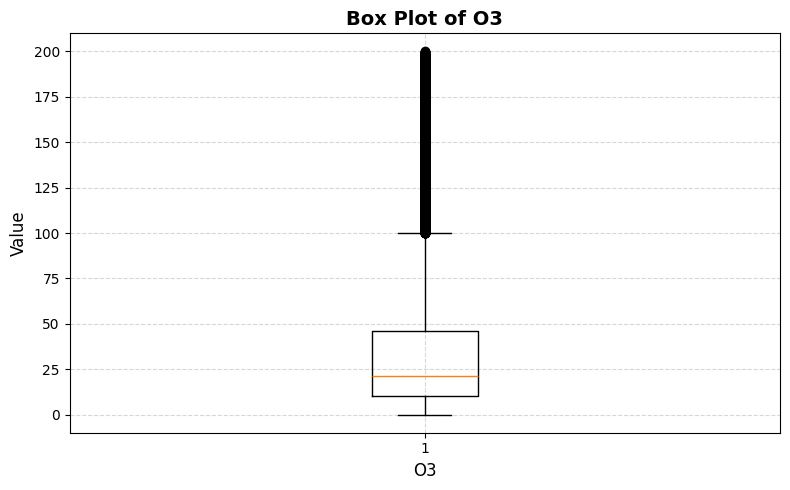

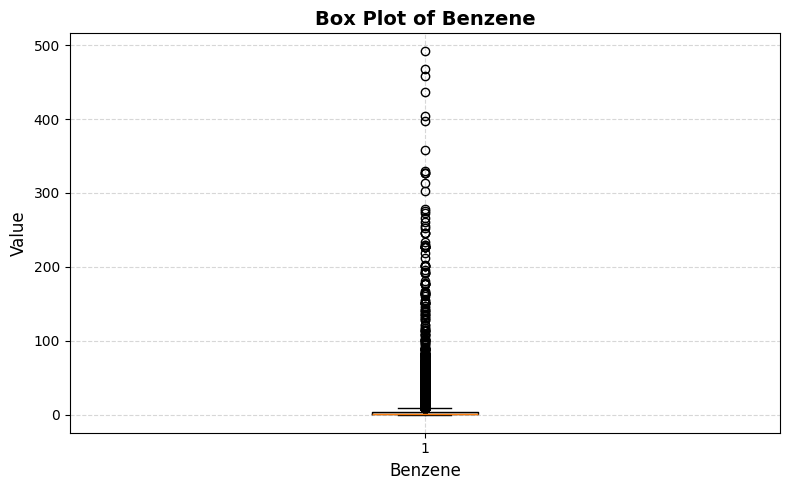

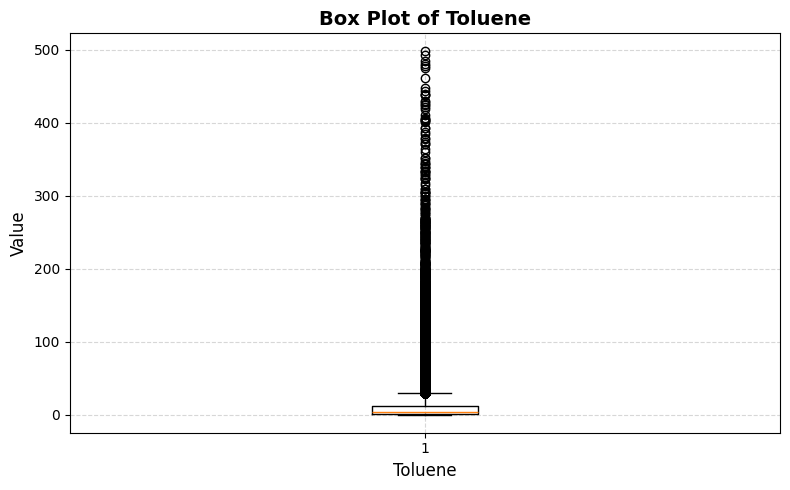

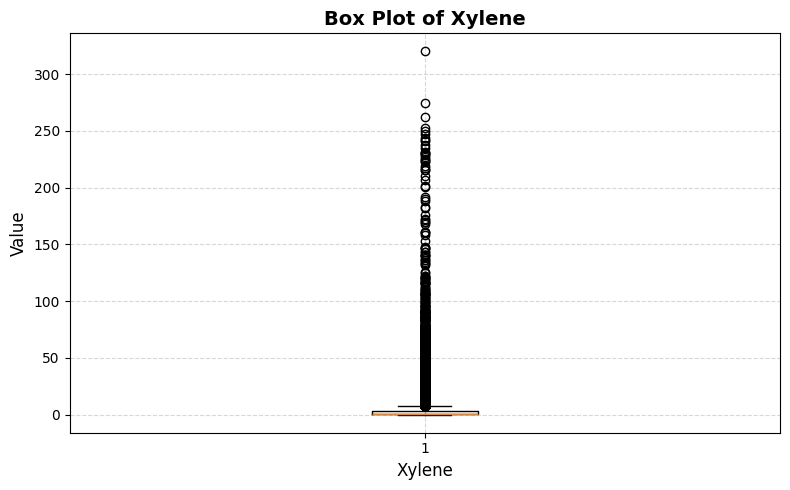

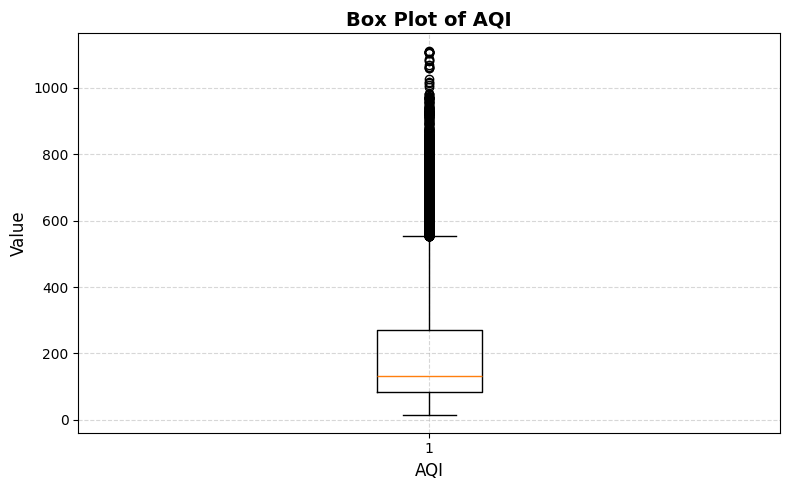

In [ ]:
for col in numerical_cols:
    plt.figure(figsize=(8, 5))

    plt.boxplot(df[col].dropna())

    # Titles and labels
    plt.title(f'Box Plot of {col}', fontsize=14, fontweight='bold')
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Value', fontsize=12)

    plt.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()


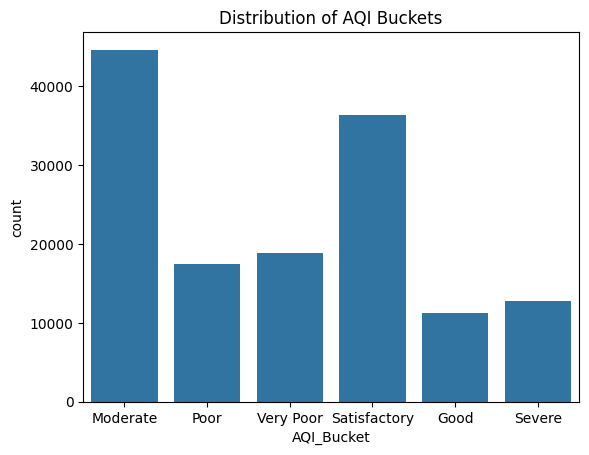

AQI_Bucket
Moderate        31.622853
Satisfactory    25.708231
Very Poor       13.307015
Poor            12.374283
Severe           9.045226
Good             7.942392
Name: proportion, dtype: float64

In [ ]:
sns.countplot(x='AQI_Bucket', data=df)
plt.title("Distribution of AQI Buckets")
plt.show()

df['AQI_Bucket'].value_counts(normalize=True)*100

## Bivariate Analysis

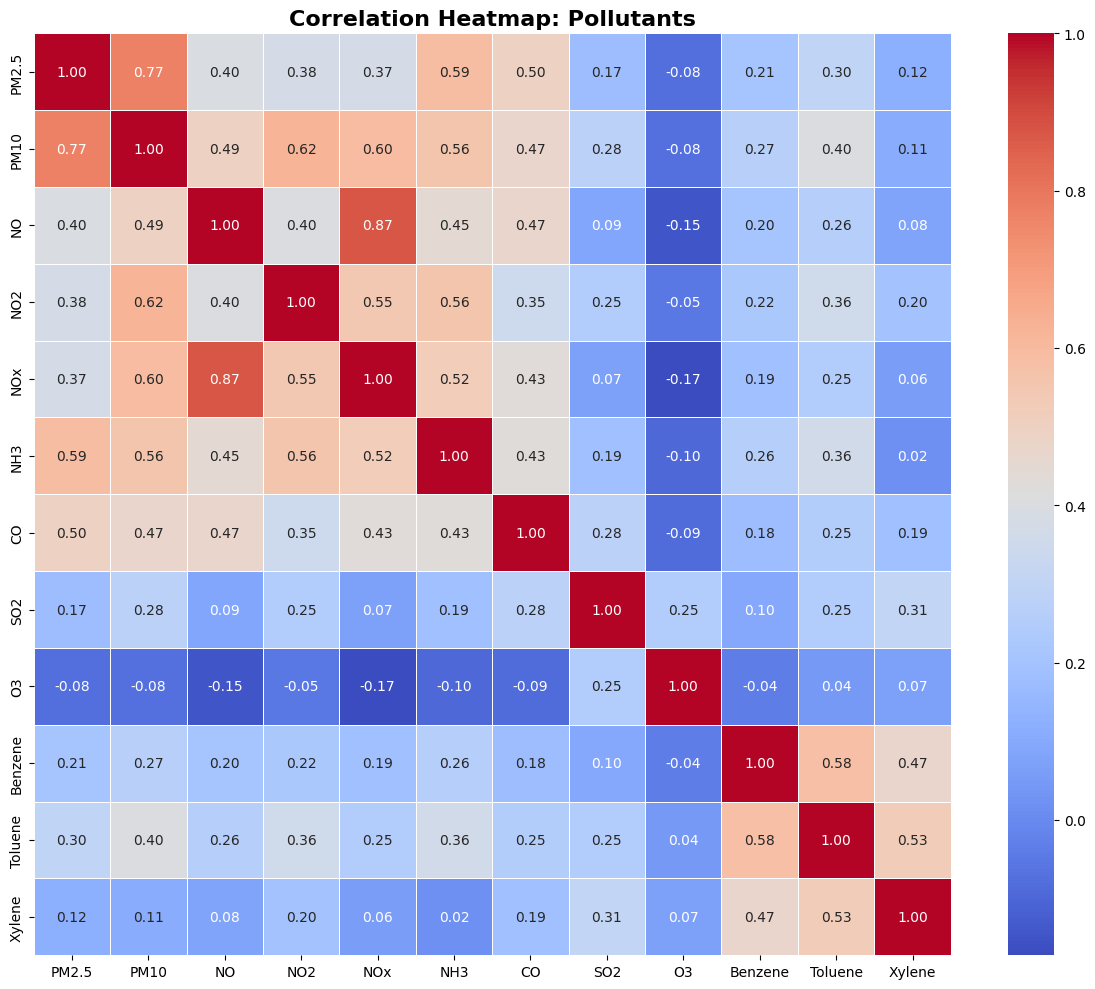

In [ ]:
pollutants = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','Benzene','Toluene','Xylene']

plt.figure(figsize=(12,10))
sns.heatmap(df[pollutants].corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap: Pollutants", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

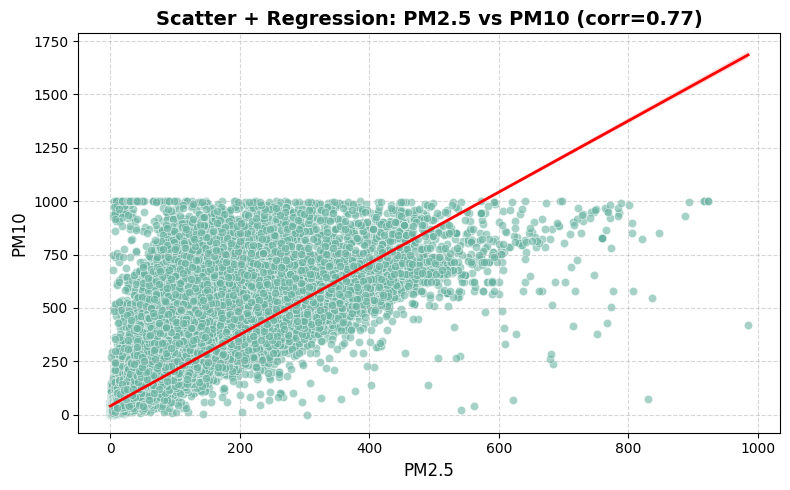

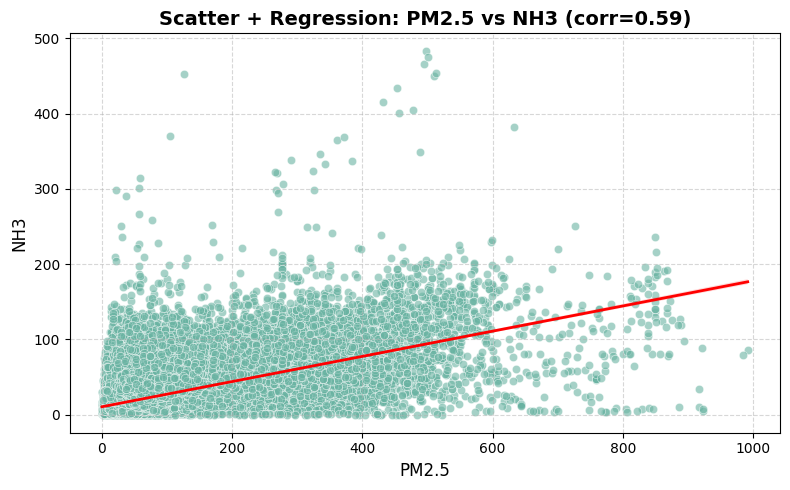

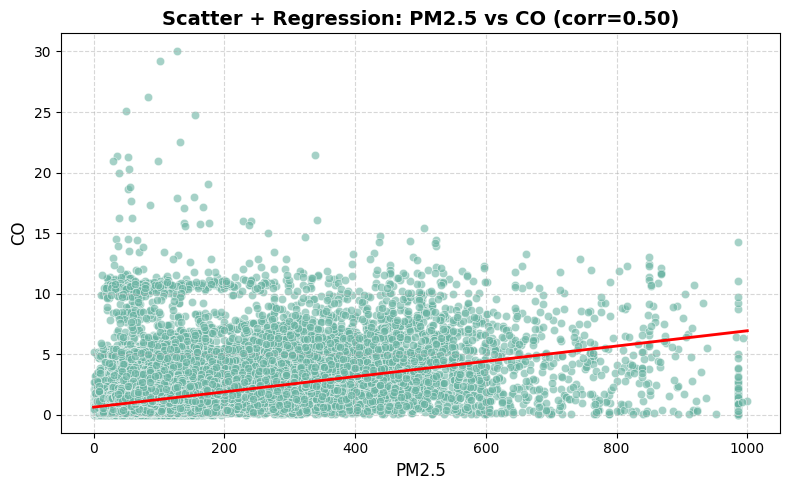

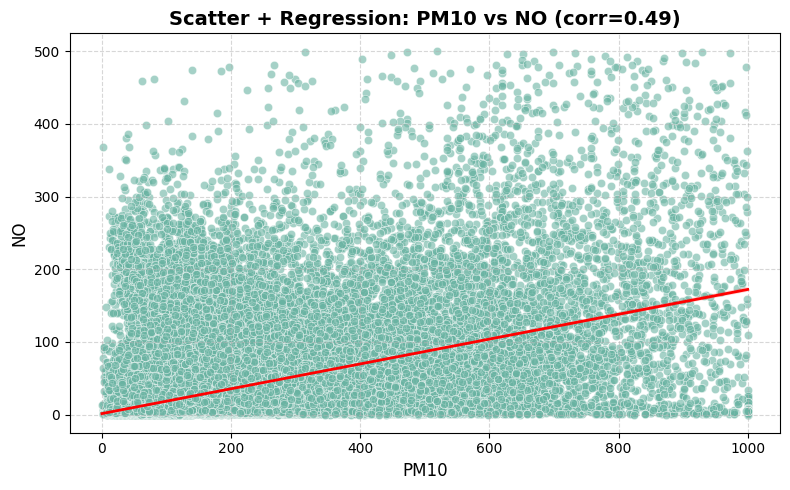

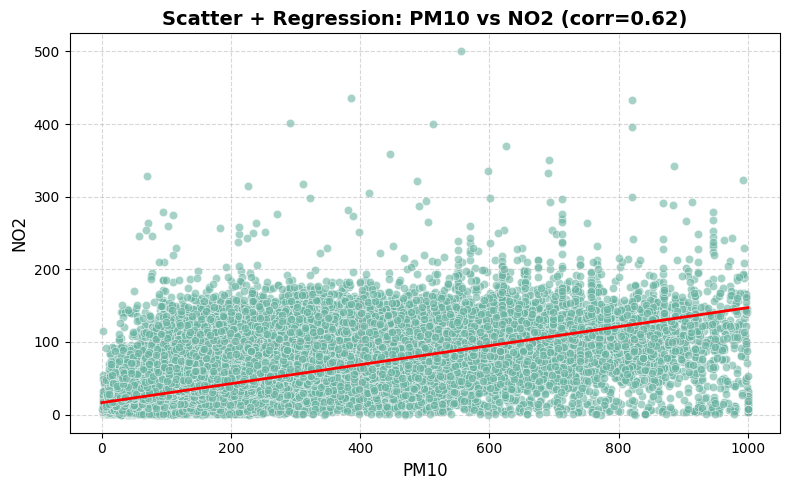

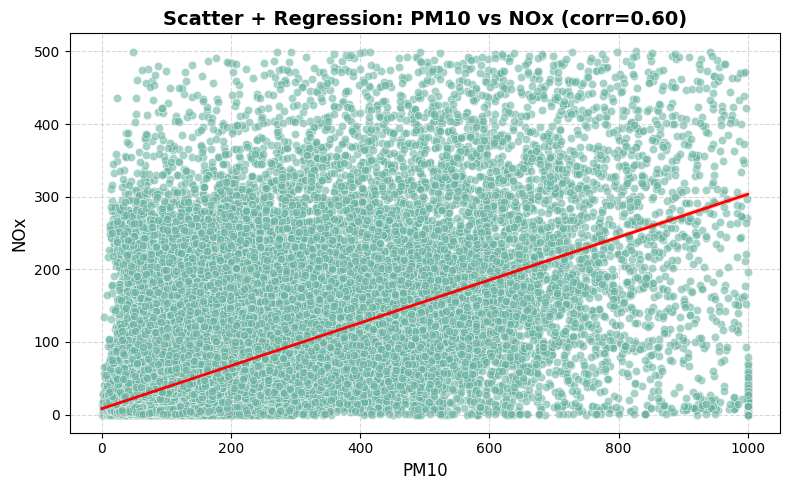

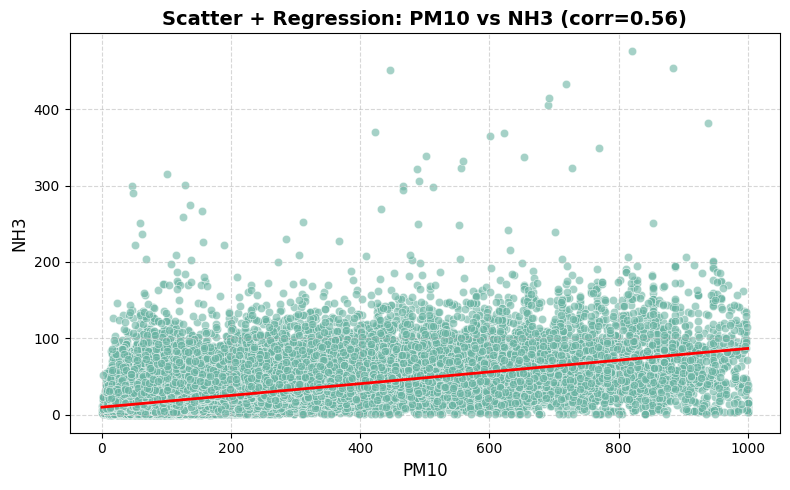

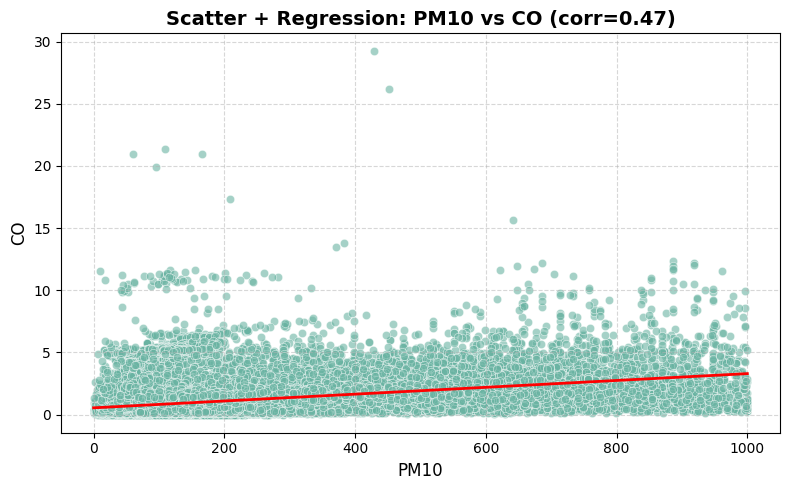

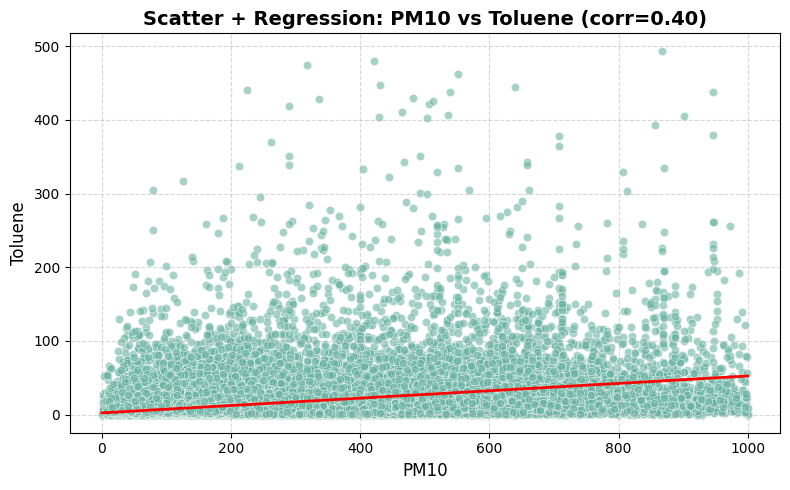

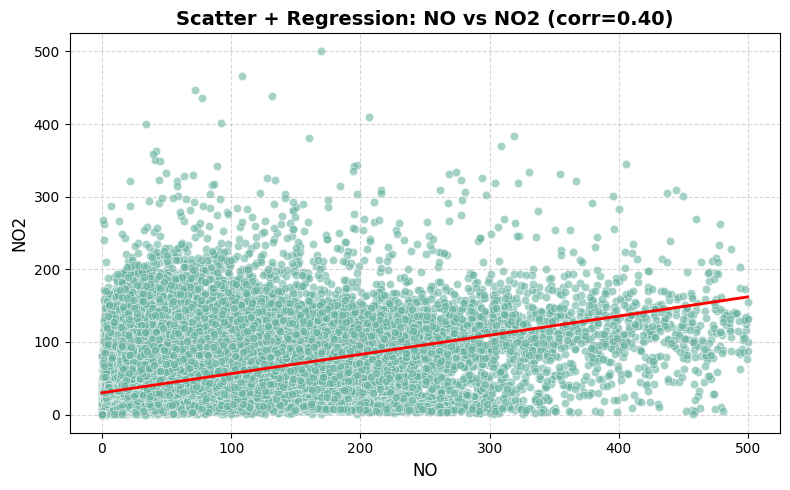

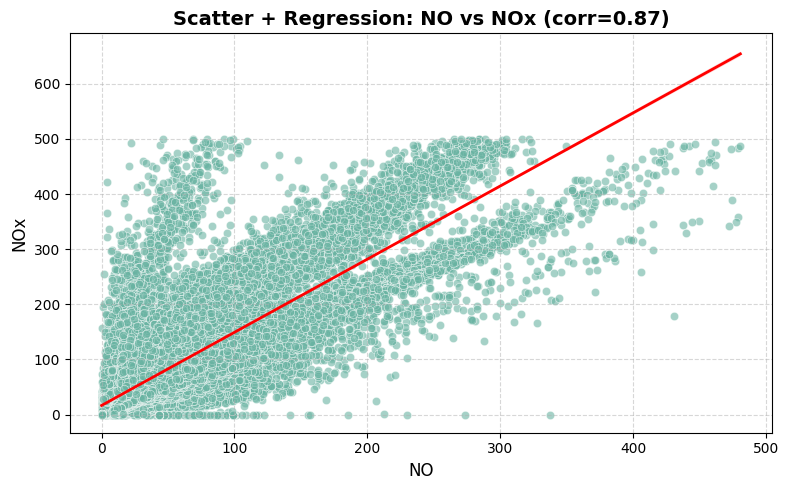

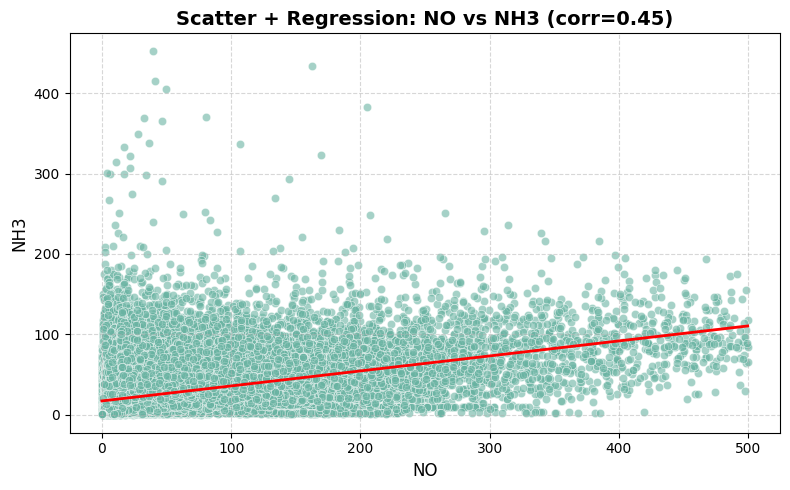

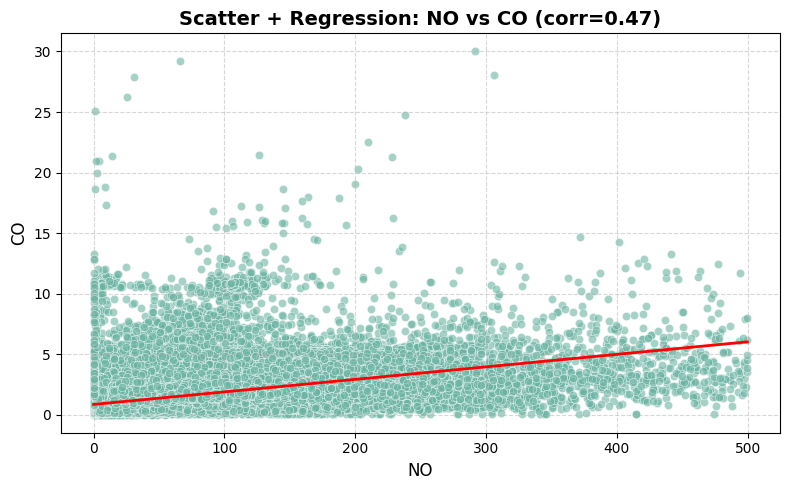

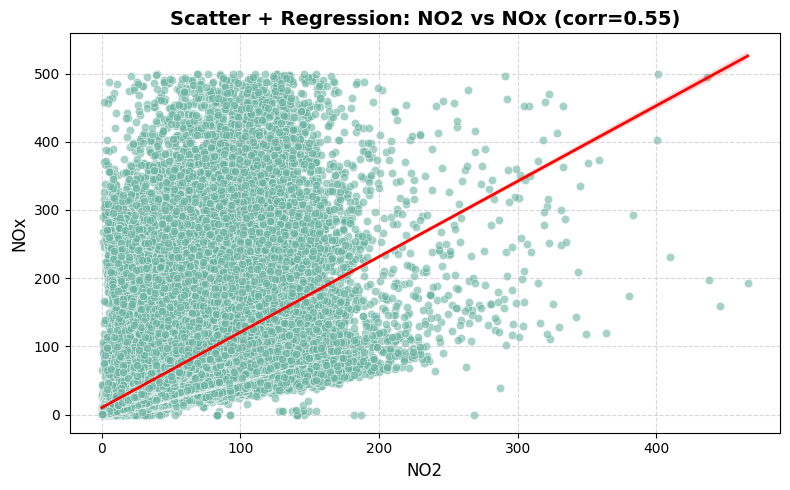

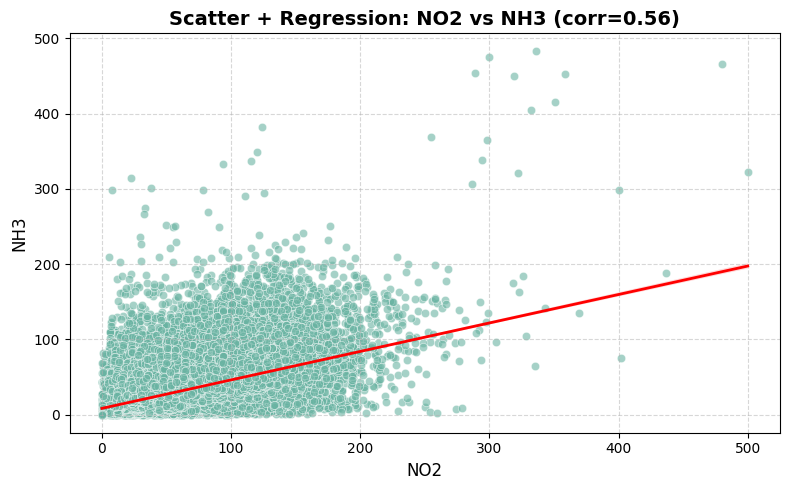

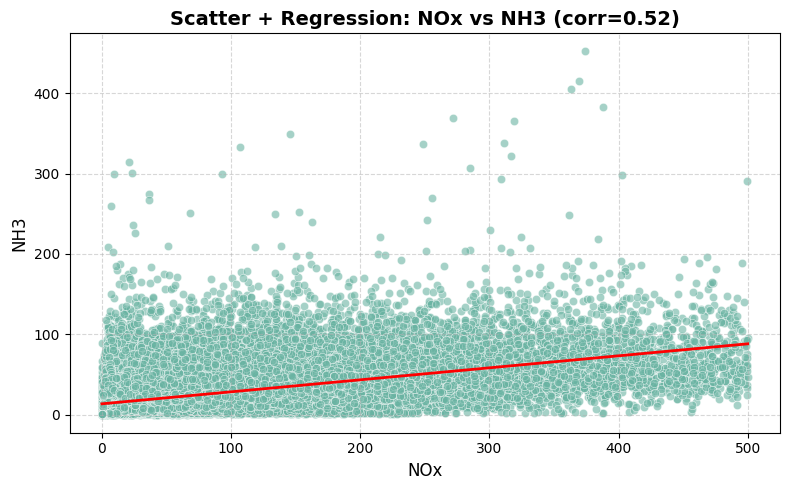

KeyboardInterrupt: 

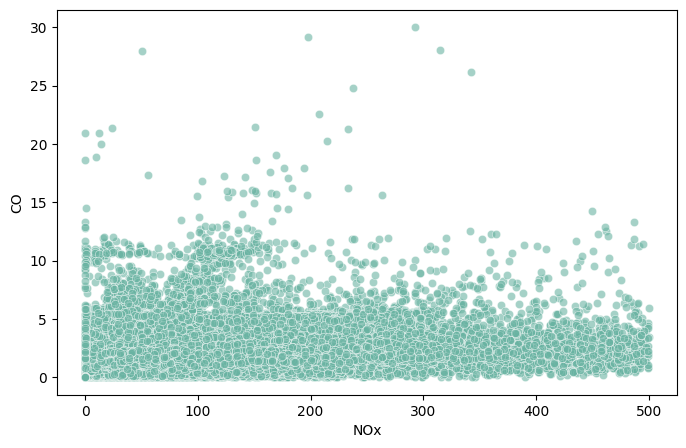

In [ ]:
import itertools

corr_matrix = df[pollutants].corr()

# Threshold for “relatedness”
threshold = 0.4

pairs = list(itertools.combinations(pollutants, 2))

for x_col, y_col in pairs:
    corr_value = corr_matrix.loc[x_col, y_col]
    if abs(corr_value) >= threshold:  # only plot if correlated enough
        plt.figure(figsize=(8,5))
        sns.scatterplot(x=x_col, y=y_col, data=df, alpha=0.6, color='#69b3a2')
        sns.regplot(x=x_col, y=y_col, data=df, scatter=False, color='red', line_kws={'linewidth':2})
        plt.title(f'Scatter + Regression: {x_col} vs {y_col} (corr={corr_value:.2f})', fontsize=14, fontweight='bold')
        plt.xlabel(x_col, fontsize=12)
        plt.ylabel(y_col, fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

In [ ]:
corr_with_aqi = df[pollutants + ['AQI']].corr()['AQI'].drop('AQI')

for col in pollutants:
    corr_value = corr_with_aqi[col]
    if abs(corr_value) >= threshold:
        plt.figure(figsize=(8,5))
        sns.scatterplot(x=col, y='AQI', data=df, alpha=0.6, color='#69b3a2')
        sns.regplot(x=col, y='AQI', data=df, scatter=False, color='red', line_kws={'linewidth':2})
        plt.title(f'{col} vs AQI (corr={corr_value:.2f})', fontsize=14, fontweight='bold')
        plt.xlabel(col, fontsize=12)
        plt.ylabel('AQI', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

In [ ]:
for col in pollutants:
    plt.figure(figsize=(8,5))

    sns.boxplot(x='AQI_Bucket' , y=col , data=df)

    plt.title(f'Box Plot of {col} by AQI Bucket', fontsize=14, fontweight='bold')
    plt.xlabel('AQI Bucket', fontsize=12)
    plt.ylabel(col, fontsize=12)

    plt.show()

In [ ]:
for col in pollutants:
  plt.figure(figsize=(8,5))

  sns.barplot(x='AQI_Bucket' , y=col , data=df)

  plt.title(f'Bar Plot of {col} by AQI Bucket', fontsize=14, fontweight='bold')
  plt.xlabel('AQI Bucket', fontsize=1)

  plt.show()

# Train test split

In [81]:
numerical_cols = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','Benzene','Toluene','Xylene']
target_col = 'AQI'

df = df.dropna(subset=['AQI'])
X = df[numerical_cols]
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Outlier Removal

In [82]:
def capping_outliers(X, cols):
    X = pd.DataFrame(X, columns=numerical_cols)
    for col in cols:
        Q1 = X[col].quantile(0.25)
        Q3 = X[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Cap values at lower and upper bounds
        X[col] = np.where(
            X[col] < lower_bound,
            lower_bound,

            np.where(
                X[col] > upper_bound,
                upper_bound,
                X[col]
            )
        )

    return X.values

In [83]:
# Wrap your function into a transformer
outlier_transformer = FunctionTransformer(capping_outliers, kw_args={'cols': numerical_cols})

# Linear Regerssion

In [ ]:
numeric_transformer_lr = Pipeline(steps=[
    ('imputer', IterativeImputer()),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ('scaler', StandardScaler()),
])

In [ ]:
preprocessor_lr = ColumnTransformer([
    ('num', numeric_transformer_lr, numerical_cols)
])

In [ ]:
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor_lr),  # your ColumnTransformer pipeline
    ('regressor', LinearRegression())
])

# Use cross-validation to get R² scores
scores_lr = cross_val_score(pipeline_lr, X_train, y_train , cv=5, scoring='r2')
print(f"Linear Regression R²: {scores_lr.mean():.4f}")

# Decision Tree

In [108]:
numeric_transformer_dt = Pipeline(steps=[
    ('imputer', IterativeImputer()),
])

In [109]:
preprocessor_dt = ColumnTransformer([
    ('num', numeric_transformer_dt, numerical_cols)
])

In [110]:
pipeline_dt = Pipeline(steps=[
    ('preprocessor', preprocessor_dt),  # your ColumnTransformer pipeline
    ('regressor', DecisionTreeRegressor(random_state=42))
])

In [111]:
param_grid_dt = {
    'regressor__max_depth': [5, 10, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 5],
    'regressor__max_features': [None, 'sqrt', 'log2']
}

In [112]:
grid_dt = GridSearchCV(
    pipeline_dt,
    param_grid=param_grid_dt,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

In [ ]:
grid_dt.fit(X_train, y_train)

print("Best parameters:", grid_dt.best_params_)
print("Best CV R²:", grid_dt.best_score_)

scores_dt = cross_val_score(pipeline_dt, X_train, y_train, cv=5, scoring='r2')
print(f"Decision Tree baseline CV R²: {scores_dt.mean():.4f}")

# Random Forest

In [ ]:
numeric_transformer_rf = Pipeline(steps=[
    ('imputer', IterativeImputer()),
])

In [ ]:
preprocessor_rf = ColumnTransformer([
    ('num', numeric_transformer_rf, numerical_cols)
])

In [ ]:
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor_rf),  # your ColumnTransformer pipeline
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

scores_rf = cross_val_score(pipeline_rf, X_train, y_train, cv=5, scoring='r2')
print(f"Random Forest R²: {scores_lr.mean():.4f}")

In [ ]:
# param_grid_rf = {
#     'regressor__n_estimators': [100, 200, 500],
#     'regressor__max_depth': [10, 20, 30, None],
#     'regressor__min_samples_split': [2, 5, 10],
#     'regressor__min_samples_leaf': [1, 2, 5],
#     'regressor__max_features': ['sqrt', 'log2', None]
# }

In [ ]:
# grid_rf = GridSearchCV(
#     pipeline_rf,
#     param_grid=param_grid_rf,
#     cv=5,
#     scoring='r2',
#     n_jobs=-1
# )

In [ ]:
# grid_rf.fit(X_train, y_train)

# # Best hyperparameters
# print("Best parameters:", grid_rf.best_params_)

# # Cross-validated R² using best estimator
# best_rf = grid_rf.best_estimator_
# scores_cv = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
# print(f"Random Forest CV R²: {scores_cv.mean():.4f}")

# K Nearest Neighboors

In [ ]:
numeric_transformer_knn = Pipeline(steps=[
    ('imputer', IterativeImputer()),
    ('cap_outliers', outlier_transformer),
    ('scaler', StandardScaler()),
])

In [ ]:
preprocessor_knn = ColumnTransformer([
    ('num', numeric_transformer_knn, numerical_cols)
])

In [ ]:
pipeline_knn = Pipeline(steps=[
    ('preprocessor', preprocessor_knn),  # your ColumnTransformer pipeline
    ('regressor', KNeighborsRegressor(n_neighbors=5))
])

# scores_knn = cross_val_score(pipeline_knn, X_train, y_train, cv=5, scoring='r2')
# print(f"K nearest neighboors R²: {scores_lr.mean():.4f}")

In [ ]:
param_grid_knn = {
    'regressor__n_neighbors': [3, 5, 7],
    'regressor__weights': ['uniform', 'distance'],
    'regressor__p': [1, 2]  # Manhattan (1) or Euclidean (2)
}

In [ ]:
grid_knn = GridSearchCV(
    pipeline_knn,
    param_grid=param_grid_knn,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

In [ ]:
grid_knn.fit(X_train, y_train)

# Best hyperparameters
print("Best parameters:", grid_knn.best_params_)

# Cross-validated R² using best estimator
best_knn = grid_knn.best_estimator_
scores_cv = cross_val_score(best_knn, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
print(f"KNN CV R²: {scores_cv.mean():.4f}")

# XGBoost

In [ ]:
numeric_transformer_xgb = Pipeline(steps=[
    ('imputer', IterativeImputer()),
])

In [ ]:
preprocessor_xgb = ColumnTransformer([
    ('num', numeric_transformer_xgb, numerical_cols)
])

In [ ]:
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor_xgb),  # your ColumnTransformer pipeline
    ('regressor', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])

scores_xgb = cross_val_score(pipeline_xgb, X_train, y_train, cv=5, scoring='r2')
print(f"XGBoost R²: {scores_lr.mean():.4f}")

In [ ]:
# param_grid_xgb = {
#     'regressor__n_estimators': [100, 200, 500],
#     'regressor__max_depth': [3, 5, 7, 10],
#     'regressor__learning_rate': [0.01, 0.05, 0.1],
#     'regressor__subsample': [0.6, 0.8, 1.0],
#     'regressor__colsample_bytree': [0.6, 0.8, 1.0],
#     'regressor__min_child_weight': [1, 3, 5]
# }

In [ ]:
# grid_xgb = GridSearchCV(
#     pipeline_xgb,
#     param_grid=param_grid_xgb,
#     cv=5,
#     scoring='r2',
#     n_jobs=-1
# )

In [ ]:
# grid_xgb.fit(X_train, y_train)

# # Best hyperparameters
# print("Best parameters:", grid_xgb.best_params_)

# # Cross-validated R² using best estimator
# best_xgb = grid_xgb.best_estimator_
# scores_cv = cross_val_score(best_xgb, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
# print(f"XGBoost CV R²: {scores_cv.mean():.4f}")

# ANN

In [ ]:
numeric_transformer_ann = Pipeline(steps=[
    ('imputer', IterativeImputer()),
    ('cap_outliers', outlier_transformer),
    ('power', PowerTransformer()),
    ('scaler', StandardScaler()),
    ('pca', PCA())
])

Decision Tree R²: 0.8552


In [ ]:
preprocessor_ann = ColumnTransformer([
    ('num', numeric_transformer_ann, numerical_cols)
])

Random Forest R²: 0.8552


In [ ]:
pipeline_ann = Pipeline(steps=[
    ('preprocessor', preprocessor_ann),  # your ColumnTransformer pipeline
    ('ann', MLPRegressor(hidden_layer_sizes=(64, 32),  # 2 hidden layers
                         activation='relu',           # common for regression
                         solver='adam',              # optimizer
                         learning_rate_init=0.001,
                         max_iter=5000,
                         random_state=42))
])

scores_ann = cross_val_score(pipeline_ann, X_train, y_train, cv=5, scoring='r2')
print(f"ANN R²: {scores_lr.mean():.4f}")

XGBoost R²: 0.8552
